<a href="https://colab.research.google.com/github/PatrykGluszekDS/TensorFlow-Projects-Showcase/blob/main/NN-Classification/Credit_Card_Fraud_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib, os, hashlib, json

# 🏁 1 · Project Bootstrap & Data Import

In this section:

1. Downloading the European credit-card fraud dataset (284 k samples, <1 % fraud)  
2. Loading into a Pandas dataframe and running a quick sanity check


In [12]:
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

df = pd.read_csv(path + "/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [13]:
print(f"Shape: {df.shape}")
print(df['Class'].value_counts(normalize=True).mul(100).round(4))

Shape: (284807, 31)
Class
0    99.8273
1     0.1727
Name: proportion, dtype: float64


🔍 **Observation:** Only **0.172 %** of transactions are fraudulent—severe class imbalance.

# 🔎 2 · Exploratory Data Analysis

Goals for this section:

* Visualise target-class imbalance  
* Inspect the € `Amount` distribution (log-scale)  
* Explore feature correlations (`V1–V28`)  
* Check fraud-rate over time

In [16]:
df['Class'].value_counts()

,count
Class,
0,284315
1,492


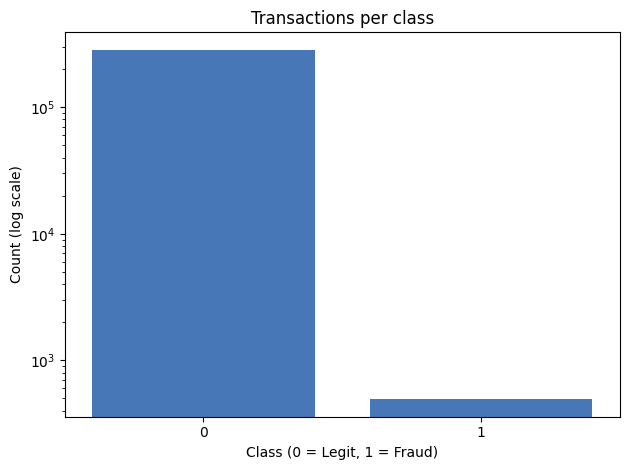

In [25]:
# Class imbalance bar plot
class_counts = df['Class'].value_counts().sort_index()

plt.figure()
sns.barplot(x=class_counts.index.astype(str),
            y=class_counts.values, color='#3475ca')
plt.yscale('log')
plt.xlabel('Class (0 = Legit, 1 = Fraud)')
plt.ylabel('Count (log scale)')
plt.title('Transactions per class')
plt.tight_layout()
plt.show()

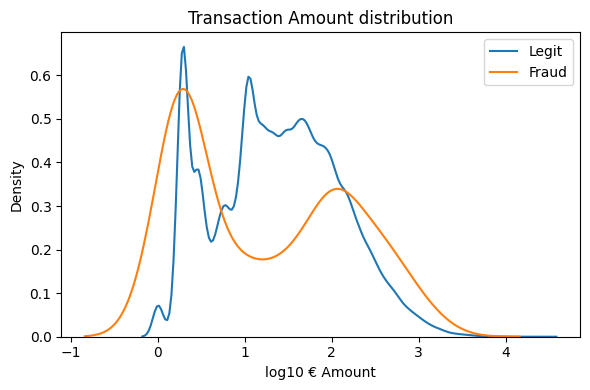

In [19]:
# Amount distribution (log10 €) by class
plt.figure(figsize=(6, 4))
for cls, label in zip([0, 1], ['Legit', 'Fraud']):
    subset = df[df['Class'] == cls]['Amount']
    sns.kdeplot(np.log10(subset + 1), label=label)
plt.xlabel('log10 € Amount')
plt.title('Transaction Amount distribution')
plt.legend()
plt.tight_layout()
plt.show()


Legit curve peaks ≈ 10¹ € (≈ €10) then trails off

Fraud has two humps — one near legit’s peak and another around log₁₀≈2 € (≈ €100).

***Fraudsters slightly prefer mid-range amounts but overlap is large → Amount alone can’t separate classes; still worth keeping after standardisation.***

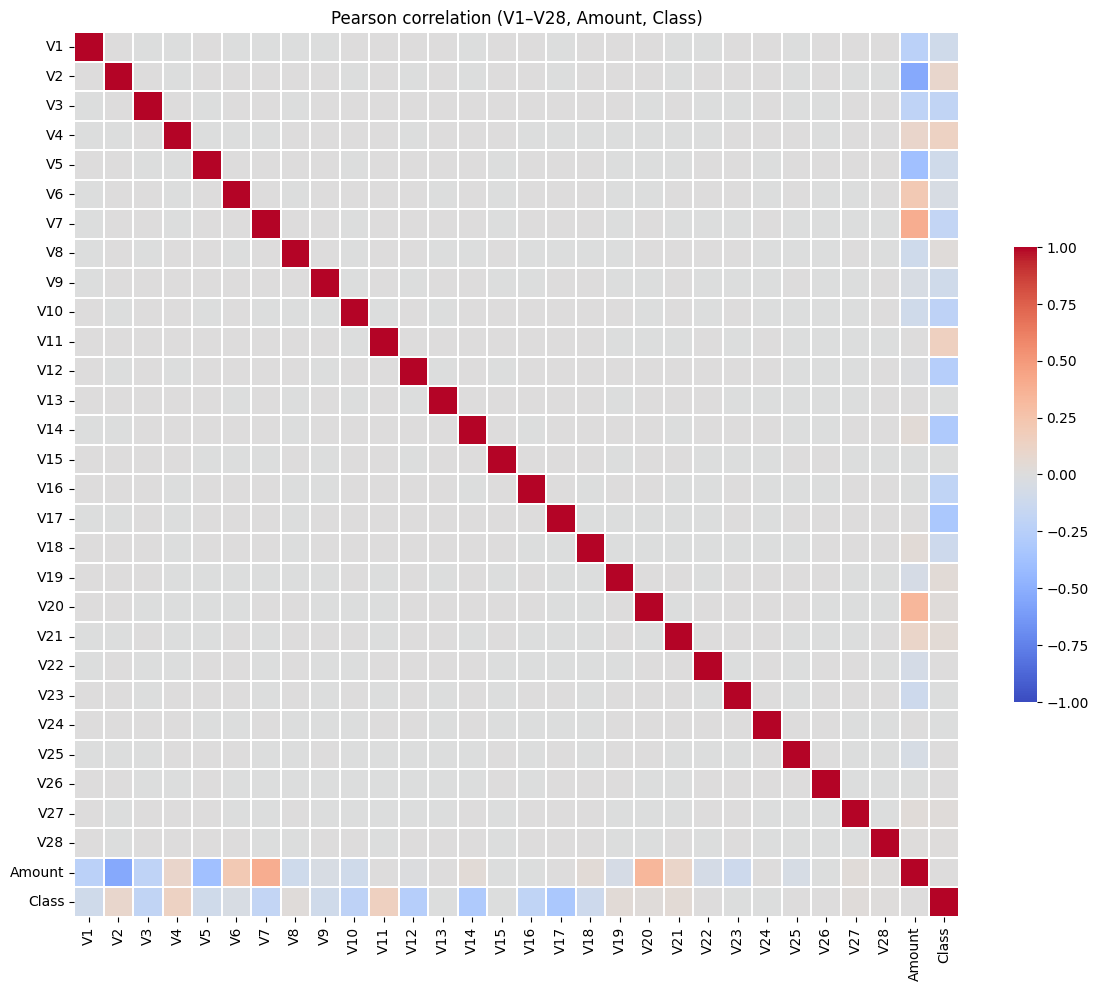

In [22]:
# Correlation heat-map
plt.figure(figsize=(12, 10))
corr = df.drop(columns=['Time']).corr()
sns.heatmap(corr, cmap='coolwarm', vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.1, cbar_kws={"shrink": .5})
plt.title('Pearson correlation (V1–V28, Amount, Class)')
plt.tight_layout()
plt.show()


Off-diagonal cells for V1-V28 are ~0 (grey). That’s expected—these are PCA components designed to be linearly uncorrelated. Amount shows weak pos/neg links with a few components (e.g. V7, V20).

***Tree models & neural nets can still exploit higher-order interactions, but classic linear models will gain little from multicollinearity tricks. No need for further decorrelation.***

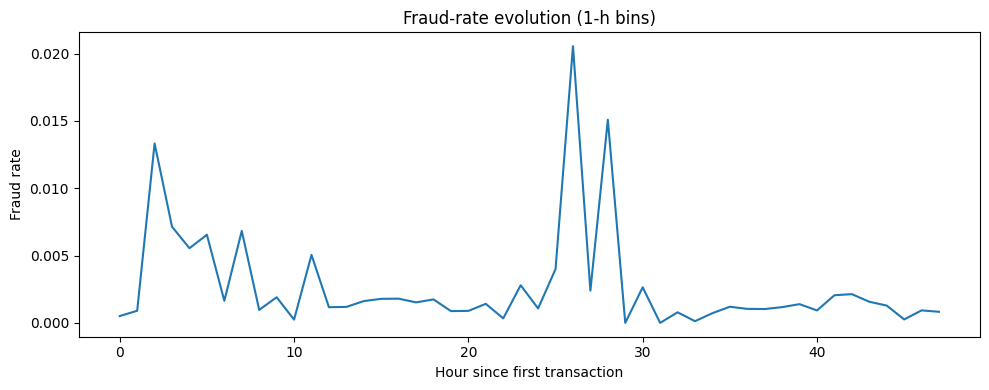

In [23]:
# Fraud rate by 1-hour bins
df['Hour'] = (df['Time'] // 3600).astype(int)
hourly = df.groupby('Hour')['Class'].agg(['sum', 'count'])
hourly['fraud_rate'] = hourly['sum'] / hourly['count']

plt.figure(figsize=(10, 4))
plt.plot(hourly.index, hourly['fraud_rate'])
plt.xlabel('Hour since first transaction')
plt.ylabel('Fraud rate')
plt.title('Fraud-rate evolution (1-h bins)')
plt.tight_layout()
plt.show()

Sharp spikes (e.g., hour ≈ 25 hits ~2 % fraud)

***Plot suggests that frauds could occur in bursts and could be coordinated attacks.***

# 🛠️ 3 · Data Pre-processing & Split